#   Credit Card Fraud Detection
### Anonymized credit card transactions labeled as fraudulent or genuine

In [1]:
#Libraries
import pandas as pd
import numpy as np
import scipy
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from pylab import rcParams
from sklearn.svm import OneClassSVM
LABELS = ["Normal","Fraud"]
import os

In [2]:
#importing the data
data = pd.read_csv("C:\\Users\\Prabhat Singh\Desktop\dataset\kaggle4\creditcard.csv")

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [5]:
#number of missing values
#data.isnull().values.any()
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Text(0.5, 0, 'class')

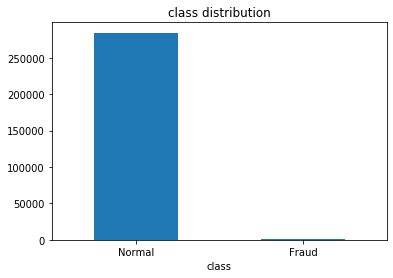

In [6]:
#exploratory data analysis
counts_classes = pd.value_counts(data.Class, sort= True)
counts_classes.plot(kind="bar",rot=0)
plt.title("class distribution")
plt.xticks(range(2),LABELS)
plt.xlabel("class")

### we can see, this is a highly imbalanced data as the number of Fraud cases is very less than that of Normal

In [7]:
fraud =  data[data["Class"]==1]
normal = data[data["Class"]==0]

In [8]:
print(f"fraud.shape: {fraud.shape}")
print(f"normal.shape: {normal.shape}")

fraud.shape: (492, 31)
normal.shape: (284315, 31)


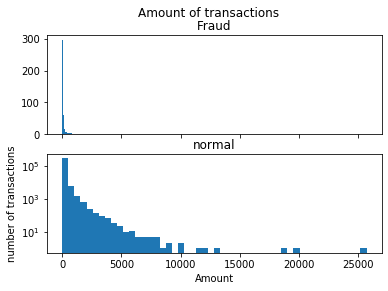

In [9]:
f,(ax1, ax2)= plt.subplots(2, 1, sharex=True)
f.suptitle("Amount of transactions")
ax1.hist(fraud.Amount,bins=50)
ax1.set_title("Fraud")
ax2.hist(normal.Amount,bins=50)
ax2.set_title("normal")
plt.ylabel("number of transactions")
plt.xlabel("Amount")
plt.yscale("log")
plt.show()

In [10]:
#Since the data is big we will take the sample of the data ie 10% of the original data
# and also because we want to apply local outlier
data1 = data.sample(frac=0.1,random_state=1)

In [11]:
#shape of new data
data1.shape

(28481, 31)

In [12]:
# number of fraud and normal in new dataset
fraud = data1[data1["Class"]==1]
valid = data1[data1["Class"]==0]
outlier= len(fraud)/len(valid)

In [13]:
print(f"The fraud cases: {len(fraud)}")
print(f"The valid cases: {len(normal)}")
print(outlier)

The fraud cases: 49
The valid cases: 284315
0.0017234102419808666


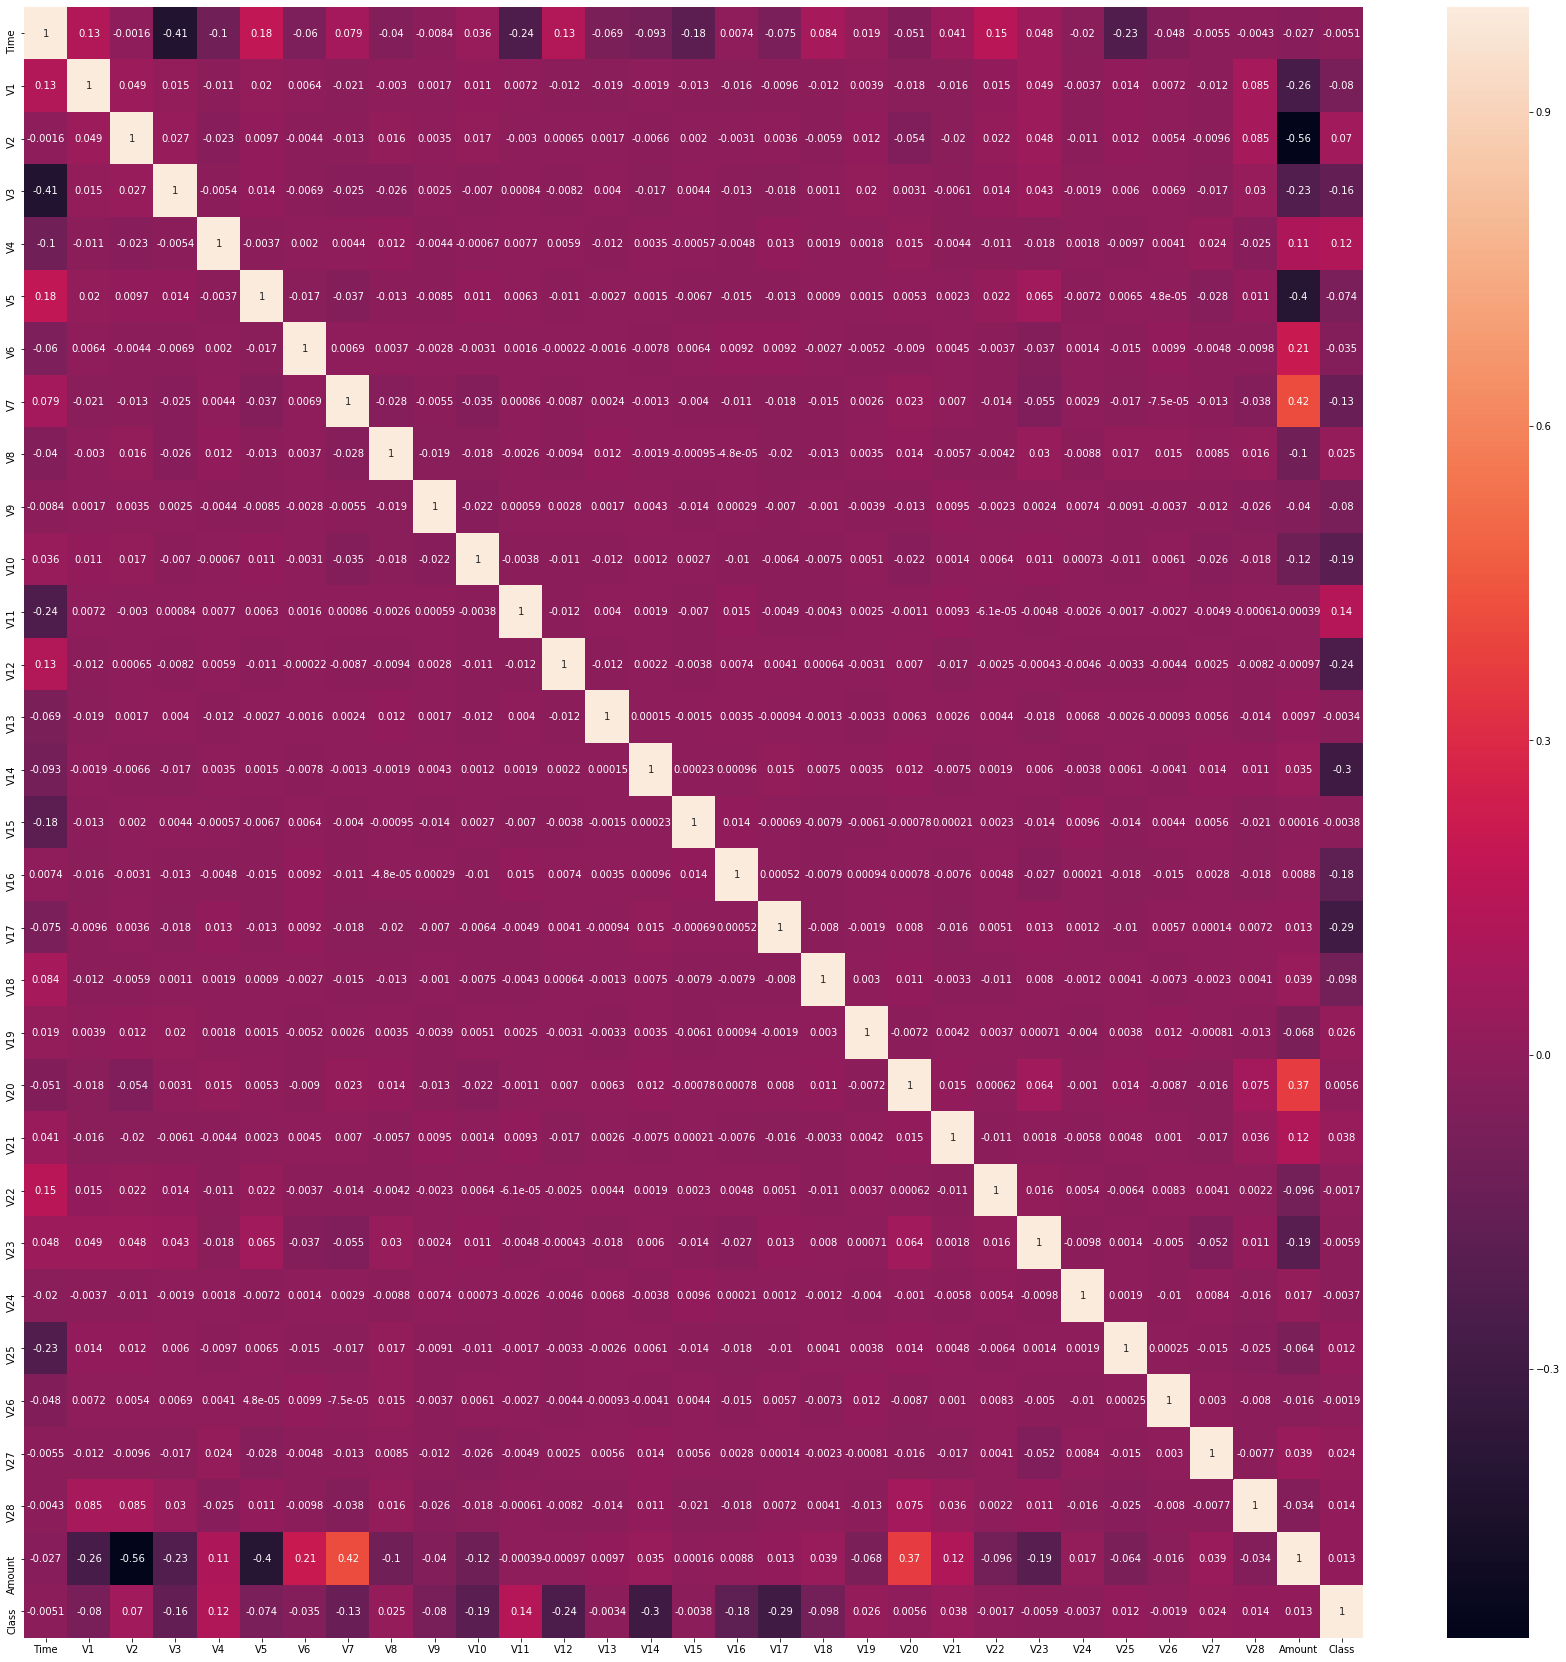

In [14]:
#correlation
cor = data1.corr()
plt.figure(figsize=(30,30))
g=sns.heatmap(cor,annot=True)

In [15]:
#creating the independent data
columns = data.columns.tolist()
columns = [c for c in columns if c not in ["Class"]]
target ="Class"
state = np.random.RandomState(42)
X = data1[columns]
X_outliers = state.uniform(low=-4, high=4, size=(20, 2))
y = data1[target]


In [16]:
print(X.shape)
print(y.shape)

(28481, 30)
(28481,)


In [17]:
#outlier detection method
classifers = {
    "Isolation_Forest": IsolationForest(n_estimators=100,max_samples=len(X),contamination=outlier,random_state=0,verbose=0),
    "Local_Outlier_Factor":LocalOutlierFactor(n_neighbors=20,algorithm="auto",leaf_size=30, metric="minkowski",p=2, metric_params=None,contamination=outlier),
    "Support_Vector": OneClassSVM(kernel="rbf", degree=3,gamma=0.1,nu=0.05,max_iter=-1,random_state=0)
    
}

In [22]:
n_outliers = len(fraud)
for i, (clf_name,clf) in enumerate(classifers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local_Outlier_Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support_Vector":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
        #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(y,y_pred))
    print("Classification Report :")
    print(classification_report(y,y_pred))
        

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Isolation_Forest: 75
Accuracy Score :
0.9973666654962958
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.24      0.24      0.24        49

    accuracy                           1.00     28481
   macro avg       0.62      0.62      0.62     28481
weighted avg       1.00      1.00      1.00     28481

Local_Outlier_Factor: 97
Accuracy Score :
0.9965942207085425
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\classes.py:1185: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


Support_Vector: 8516
Accuracy Score :
0.7009936448860644
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     28432
           1       0.00      0.37      0.00        49

    accuracy                           0.70     28481
   macro avg       0.50      0.53      0.41     28481
weighted avg       1.00      0.70      0.82     28481



   ### Observation
   #### Isolation Forest detected 75 errors || Locat outlier detected 97 || SVm detected 8516
   #### Isolation Forest has a 99.73% more accurate than LOF of 99.65% and SVM of 70.09
   #### So overall Isolation Forest Method performed much better in determining the fraud cases.